<a href="https://colab.research.google.com/github/vellic0ncent/Recommender_systems/blob/main/Recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предыстория об исходных данных

1. **WARNING!** Датасет не относится к публичным, поэтому **любое его распространение запрещено**. По этой же причине полный доступ к исходным данным не открываем. В ходе работы будут представлены только его фрагменты для понимания сущностей, с которыми работаем.
2. Датасет относится к **сфере электронной коммерции (E-commerce)**. Обоснования актуальности выбор этих данных не требует, поскольку такие рекомендательные системы хорошо монетизируются.
3. Датасет состоит на **95% из качественных показателей**.
4. Датасет **нормализован**.
5. Датасет собран из трёх потоков данных: кэшированные данные о **географии пользователя и его устройства**, данные о **факте совершенной покупки и продукте**, данные CJM (**customer journey map**) о просмотренных пользователем продуктах.
6. Источник данных - условно-бесплатный **сервис веб-аналитики Google Analytics 360**. Хранение денормализованных данных - **Google Cloud Platform ( GCP )**. Выгрузка данных - **Google Cloud Storage** в формате csv.

Представим источник с данными. На картинке ниже - уже агрегированный в Google Storage в "buckets"-датасет в виде 100 .csv файлов (количество файлов = количеству потоков при загрузке с GCP):

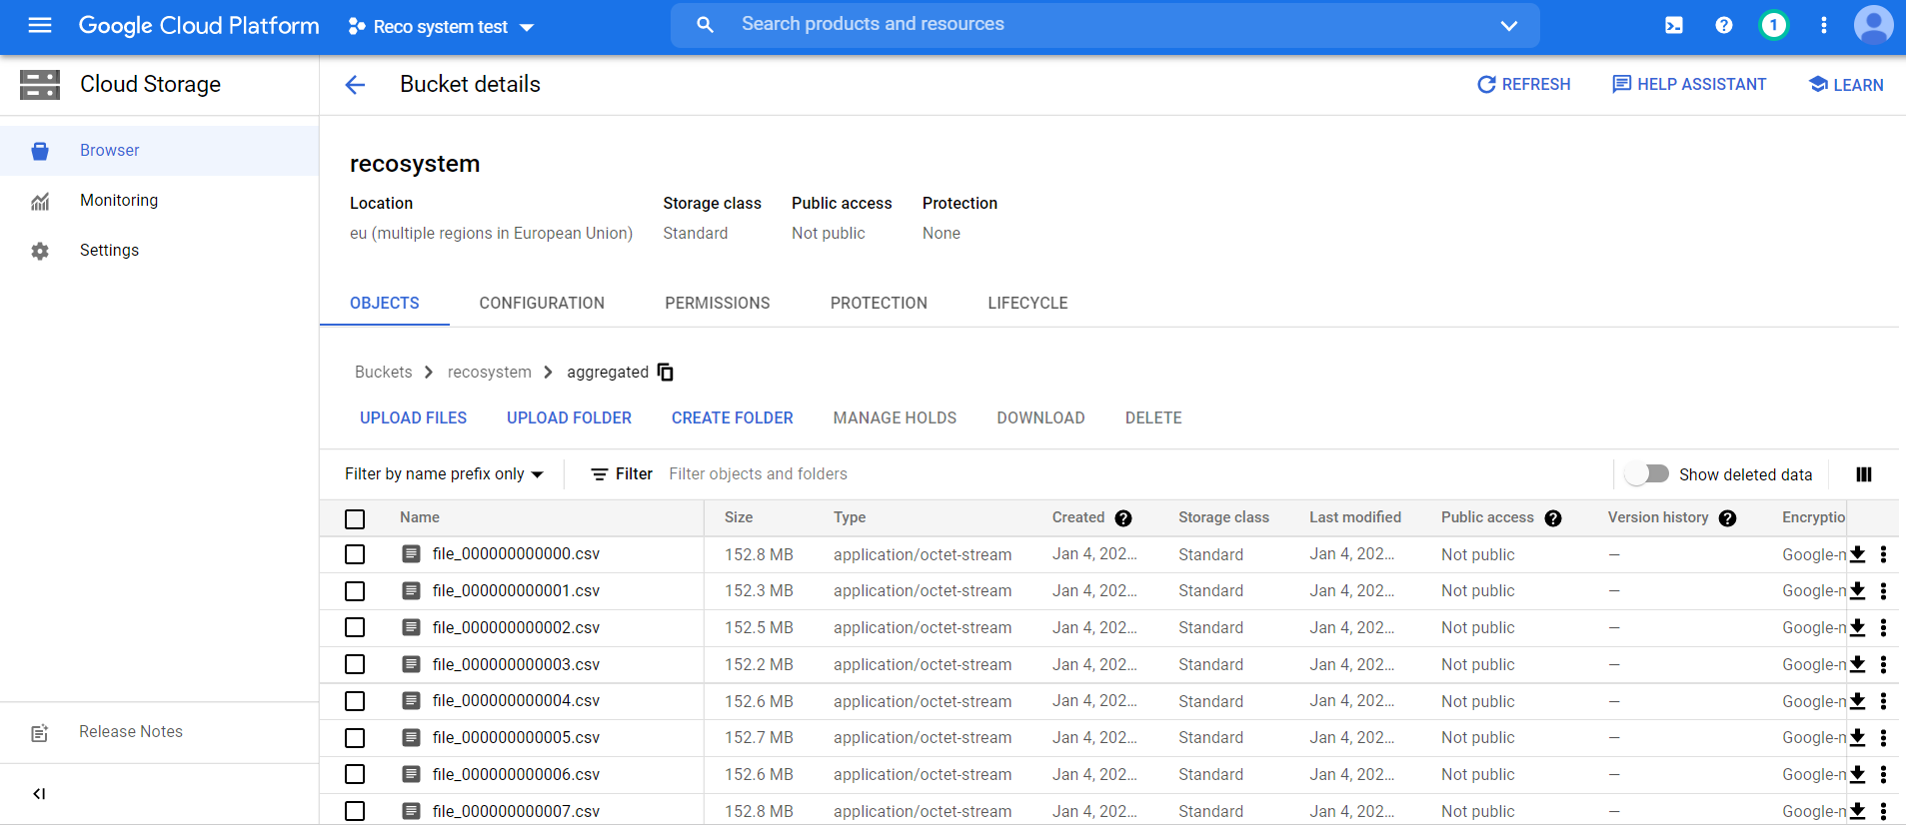

Схема данных с сущностями и их типами представлена ниже:

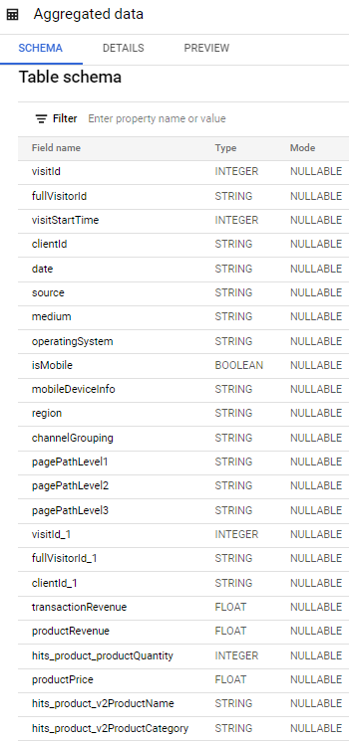

# Import libraries

Не используем готовые библиотеки для рекоммендаций, только хардкор.

In [88]:
!pip install anvil-uplink

     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 190 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=9eb12ce16d5ff3d6f4fd74ad95f7effa77cbbd15b395621b900442106985a680
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [1]:
import os
import re
import math
import scipy
import sklearn
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm
from statistics import median
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
import anvil.server

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variables

In [3]:
# ROOT_PATH = r"C:\Users\Vera Pushkareva\Recommender system"
ROOT_PATH = r"/content/drive/MyDrive/RecommenderSystem/RawData"
ROOT_MODELS = r"/content/drive/MyDrive/RecommenderSystem/Models"

Нам пригодятся названия сущностей в явном виде (в нашем случае - это колонки, так как данные выгружались в .csv), поскольку при выгрузке worker-ы опускают названия сущностей.

In [4]:
HEADERS = [
    "visitId", "fullVisitorId", "visitStartTime", "clientId",
    "date", "source", "medium", "operatingSystem", "isMobile",
    "mobileDeviceInfo", "region", "channelGrouping",
    "pagePathLevel1", "pagePathLevel2", "pagePathLevel3",
    "visitId_1", "fullVisitorId_1", "clientId_1",
    "transactionRevenue", "productRevenue",
    "hits_product_productQuantity", "productPrice",
    "hits_product_v2ProductName", "hits_product_v2ProductCategory"
]

# Functions

In [5]:
def delete_substring_by_condition(string: str, condition: str) -> str:
    string = re.sub(condition, '', string) #'\?.*'
    return string

def is_substring_in(string: str, substring: str) -> bool:
    return substring in string

In [6]:
class RemoveScarceValuesEngineer:
    
    """
    Prepare dataframe for Encoding making classes in columns more stable by
    removing scarce values.

    :param min_occurences: float
        Min percentage of group representatives which Engineer should leave
        as they are. If group has less representatives, then the whole group 
        will be renamed in "Others".
    :return: pd.DataFrame
        DataFrame with columns prepared for encoding (more balanced classes).
    """

    def __init__(self, min_occurences: float):
        self._min_occurences = min_occurences
        self._column_value_counts = {}
        self._min_value_occurences = None

    def fit(self, dataframe):
        for column in dataframe.columns:
            self._column_value_counts[column] = dataframe[column].value_counts()
        return self

    def transform(self, dataframe):
        for column in dataframe.columns:
            self._min_value_occurences = int(self._min_occurences*sum(self._column_value_counts[column]))
            dataframe.loc[self._column_value_counts[column][dataframe[column]].values
                  < self._min_value_occurences, column] = "Others"

        return dataframe

    def fit_transform(self, dataframe):
        self.fit(dataframe)
        return self.transform(dataframe)

In [7]:
def prepare_sample(dataframe) -> pd.DataFrame:
#     dataframe[HEADERS[:18]] = dataframe[HEADERS[:18]].fillna("(not set)")
    dataframe[HEADERS[:15]] = dataframe[HEADERS[:15]].fillna(value="(not set)")
#     dataframe = dataframe.fillna("(not set)")
    dataframe.drop(["visitId_1", "fullVisitorId_1", "clientId_1",
                    "productRevenue", "hits_product_productQuantity",
                    'visitId', 'fullVisitorId', 'visitStartTime', 'date'], axis=1, inplace=True)
    
    dataframe["isFilter"] = dataframe.pagePathLevel1.apply(lambda x:is_substring_in(string=x, substring="filter"))
    dataframe["isSort"] = dataframe.pagePathLevel1.apply(lambda x: is_substring_in(string=x, substring="sort"))                                          
    dataframe["pagePathLevel1"] = dataframe.pagePathLevel1.apply(lambda x: delete_substring_by_condition(string=x, condition='\?.*'))
    dataframe["pagePathLevel2"] = dataframe.pagePathLevel2.apply(lambda x: delete_substring_by_condition(string=x, condition='\?.*'))
    dataframe["pagePathLevel3"] = dataframe.pagePathLevel3.apply(lambda x: delete_substring_by_condition(string=x, condition='\?.*'))
    
    rsvEngineer = RemoveScarceValuesEngineer(min_occurences=0.01)
    dataframe[["source", "medium","operatingSystem",
               "mobileDeviceInfo", "region", "channelGrouping",
              ]] = rsvEngineer.fit_transform(dataframe[[
                                    "source", "medium", "operatingSystem", "mobileDeviceInfo",
                                    "region", "channelGrouping",
                                ]])
    return dataframe

In [8]:
def calc_median(dataframe: pd.DataFrame, col_name: str):
    return median(dataframe.dropna(subset=[col_name])[col_name])

In [9]:
def contains_digit(string: str):
    return any(map(str.isdigit, string))

In [10]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [11]:
def get_items_interacted(person_id, interactions_df) -> set:
    # Get the user's data and merge in.
    interacted_items = interactions_df.loc[person_id]['hits_product_v2ProductName_']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [12]:
def get_checklist_users(top_n: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe[dataframe["hitType"]=="PURCHASE"]["clientId"].astype(str).unique()[:top_n]

In [13]:
def get_purchases(dataframe: pd.DataFrame, user_id: str,
                  product_name_column="hits_product_v2ProductName") -> pd.DataFrame:
    dataframe["clientId"] = dataframe["clientId"].astype(str)
    return dataframe[dataframe["clientId"] == user_id][product_name_column].unique()

In [14]:
def recommend(user_id: str, model:object,
              product_map: dict,
              product_id_column="hits_product_v2ProductName_",
              product_name_column="hits_product_v2ProductName") -> list:
    recommended_goods = model.recommend_items(user_id)
    if product_name_column in recommended_goods.columns:
        pass
    else:
        recommended_goods[product_name_column] = recommended_goods["hits_product_v2ProductName_"].map(product_map)
    return recommended_goods[product_name_column].unique()

In [15]:
def check_and_recommend_me(user_id: str, model: object, dataframe: pd.DataFrame, product_map: dict) -> tuple:
    purchased_goods = get_purchases(dataframe=dataframe, user_id=user_id)
    recommended_goods = recommend(user_id=user_id, model=model, product_map=product_map)
    return(purchased_goods, recommended_goods)

In [16]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def iterate_through_ids(ids):
    try:
        return [get_item_profile(x) for x in ids]
    except TypeError:
        return [get_item_profile(x) for x in [ids]]
        

def get_item_profiles(ids):
    item_profiles_list = iterate_through_ids(ids)
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions):
    interactions_person_df = interactions.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['hits_product_v2ProductName_'])
    
    user_item_strengths = np.array(interactions_person_df['strength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions = interactions_train_df[interactions_train_df['hits_product_v2ProductName_'] \
                                        .isin(dataframe['hits_product_v2ProductName_'])].set_index('clientId')
    user_profiles = {}
    for person_id in interactions.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions)
    return user_profiles

In [110]:
def count_recommended_and_purchased(purchased_goods: list, recommended_goods: list):
  count_recommended_and_purchased = len(set(recommended_goods).intersection(set(purchased_goods)))
  count_recommended_but_not_purchased = len(recommended_goods) - count_recommended_and_purchased
  return (count_recommended_and_purchased, count_recommended_but_not_purchased, len(recommended_goods))

def accuracy(in_target: int, total_count: int):
  return in_target / total_count

# Load data

Данные хранятся так:

In [ ]:
os.listdir(ROOT_PATH)

['aggregated_file_000000000000.csv',
 'aggregated_file_000000000001.csv',
 'aggregated_file_000000000002.csv',
 'aggregated_file_000000000003.csv',
 'aggregated_file_000000000004.csv',
 'aggregated_file_000000000005.csv',
 'aggregated_file_000000000006.csv',
 'aggregated_file_000000000007.csv',
 'aggregated_file_000000000008.csv',
 'aggregated_file_000000000009.csv',
 'aggregated_file_000000000010.csv',
 'aggregated_file_000000000011.csv',
 'aggregated_file_000000000012.csv',
 'aggregated_file_000000000013.csv',
 'aggregated_file_000000000014.csv',
 'aggregated_file_000000000032.csv',
 'aggregated_file_000000000015.csv',
 'aggregated_file_000000000016.csv',
 'aggregated_file_000000000017.csv',
 'aggregated_file_000000000018.csv',
 'aggregated_file_000000000019.csv',
 'aggregated_file_000000000020.csv',
 'aggregated_file_000000000021.csv',
 'aggregated_file_000000000022.csv',
 'aggregated_file_000000000023.csv',
 'aggregated_file_000000000024.csv',
 'aggregated_file_000000000025.csv',
 

#### Load dataset

Сформируем из N файлов выше единый датасет:

In [17]:
frames: list() = []
    
for source_file in os.listdir(ROOT_PATH)[:10]:
    frame: pd.DataFrame = prepare_sample(
        pd.read_csv(
            os.path.join(ROOT_PATH, source_file),
            names=HEADERS
        )
    )       
    frames.append(frame)
dataframe = pd.concat(frames)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Обзорная экскурсия по нашим данным (сколько записей всего, включая уникальных клиентов, которые совершили и не совершили покупку):

In [ ]:
print("Our dataset has ", len(dataframe), " rows.")
print("Our dataset has ", len(dataframe.clientId.unique()), " unique clients. Among them ",
      len(dataframe[dataframe.hits_product_v2ProductName.notnull()].clientId.unique()), " made any purchase and ",
      len(dataframe[dataframe.hits_product_v2ProductName.isnull()].clientId.unique()), " did not.")
print("So one client did on average ",
      sum(dataframe[dataframe.hits_product_v2ProductName.notnull()].groupby('clientId')['hits_product_v2ProductName'].nunique()) /\
      len(dataframe[dataframe.hits_product_v2ProductName.notnull()].clientId.unique()),
      " purchases.")

Our dataset has  7752211  rows.
Our dataset has  2882704  unique clients. Among them  75587  made any purchase and  2847780  did not.
So one client did on average  1.5990448092926033  purchases.


#### Add some quantative metrics & clean the names of goods

В качестве "base line" возьмем естественную конверсию на сайте - это 2.6%. Предполагается, что если Recall нашей системы превысит конверсию, то рекомендации подходящие.

In [18]:
conversion = len(dataframe[dataframe.hits_product_v2ProductName.notnull()].clientId.unique()) /\
                len(dataframe.clientId.unique())
conversion

0.02622086762983643

Отсюда начинается предобработка датасета для того, чтобы можно было его "положить" в рекомендательную систему.

Рекомендовать мы собираемся, естественно, продукцию, поэтому придется "причесать" сущность под названием *hits_product_v2ProductName*
1. Заполним пропуски наименований продукта 3-м уровнем глубины поиска (это как раз страница продукта).
p.s. Потеря наименования продукта возможна при слете разметки, за которую ответственный доблестный front-end.

In [19]:
dataframe["hits_product_v2ProductName"] = dataframe["hits_product_v2ProductName"] \
    .mask(dataframe["hits_product_v2ProductName"].isnull(), 
         other = dataframe["pagePathLevel3"])

2. На всякий случай также убедимся, что наша сущность (наименование продукта) содержит артикул, иначе там что-то не то. Собственно, если находим это "что-то не то" - со спокойной совестью удаляем.

In [20]:
dataframe["product_mask"] = dataframe["hits_product_v2ProductName"].apply(contains_digit)

In [21]:
dataframe = dataframe[dataframe.product_mask == True]

3. Добавим тип хита - посетитель сайта просто смотрел эту страницу, либо он купил продукт.

In [25]:
dataframe["hitType"] = dataframe.hits_product_v2ProductCategory
dataframe.loc[dataframe['hitType'].notnull(), 'hitType'] = "PURCHASE"
dataframe.loc[dataframe['hitType'].isnull(), 'hitType'] = "VIEW"

4. Посчитаем общее число действий каждого клиента на сайте за всю историю его взаимодействия и оставим только тех "заинтересованных" пользователей, кто совершил более 2 действий на сайте (посетил больше 2 страниц).

In [22]:
dataframe['actionCounts'] = dataframe['clientId'].map(dataframe['clientId'].value_counts())

In [23]:
dataframe = dataframe[dataframe['actionCounts'] > 1]

5. Оцифруем наши хиты - присвоим обычному просмотру страницы размер естественной конверсии, а действию, завершившемуся покупкой, единицу, как 100% конверсии.

In [26]:
dataframe["evaluationOfHitType"] = dataframe["hitType"].map({
    "PURCHASE": 1,
    "VIEW": conversion
})

#### Add quantative evaluation of loyalty

1. Найдем медиану всех совершенных на сайте покупок, возьмем ее за "base line". Полагая, что покупка на сумму бОльшая медианы, означает бОльшую лояльность покупателя. Тогда посчитаем *степень лояльности* наших покупателей как соотношение с медианой (больше единицы - большая лояльность).

In [27]:
median_value = calc_median(dataframe=dataframe, col_name="transactionRevenue")
dataframe["loyaltyDegree"] = dataframe["transactionRevenue"].apply(lambda x: x / median_value)
dataframe.loyaltyDegree = dataframe.loyaltyDegree.fillna(0)

In [ ]:
# scaler = MinMaxScaler()
# dataframe["sessionCounts"] = scaler.fit_transform(np.array(dataframe["sessionCounts"]).reshape(-1, 1))
# dataframe["loyaltyDegree"] = scaler.fit_transform(np.array(dataframe["loyaltyDegree"]).reshape(-1, 1))

2. Соберем из созданных выше сущностей наш количественный "рейтинг" для рекомендательной системы.

In [28]:
dataframe["strength"] = (2*dataframe["evaluationOfHitType"] + dataframe["loyaltyDegree"]) * dataframe["actionCounts"]

#### Labels Encoding for products

In [29]:
categoricals_col = ["source", "medium", "operatingSystem", "isMobile", "mobileDeviceInfo",
               "region", "channelGrouping", "pagePathLevel1", "pagePathLevel2", "pagePathLevel3",
               "hits_product_v2ProductName", "hits_product_v2ProductCategory",
               "isFilter", "isSort"]
LE = LabelEncoder()
for col in categoricals_col:
    dataframe[col+"_"] = LE.fit_transform(dataframe[col])

#### Dataset view before modelling

In [30]:
dataframe.head(3)

,clientId,source,medium,operatingSystem,isMobile,mobileDeviceInfo,region,channelGrouping,pagePathLevel1,pagePathLevel2,pagePathLevel3,transactionRevenue,productPrice,hits_product_v2ProductName,hits_product_v2ProductCategory,isFilter,isSort,product_mask,actionCounts,hitType,evaluationOfHitType,loyaltyDegree,strength,source_,medium_,operatingSystem_,isMobile_,mobileDeviceInfo_,region_,channelGrouping_,pagePathLevel1_,pagePathLevel2_,pagePathLevel3_,hits_product_v2ProductName_,hits_product_v2ProductCategory_,isFilter_,isSort_
0,1.90172e+09,tefal.ru,referral,Windows,False,(not set),Moscow,Referral,/compare/,/share/,/,9299.0,4899.0,Мультисковорода Tefal Excellence 26 см G2697772,Сковороды,False,False,True,113,PURCHASE,1.0,0.930645,331.16283,9,10,3,0,0,4,10,37,298,1,2388,66,0,0
1,1.90172e+09,tefal.ru,referral,Windows,False,(not set),Moscow,Referral,/posuda/,/skovorody/,/filter/,9299.0,1.0,Термокружка Tefal Travel Mug K3073114,Термокружки и термосы,False,False,True,113,PURCHASE,1.0,0.930645,331.16283,9,10,3,0,0,4,10,115,305,312,4108,74,0,0
2,1.90172e+09,tefal.ru,referral,Windows,False,(not set),Moscow,Referral,/posuda/,/skovorody/,/filter/,9299.0,4899.0,Мультисковорода Tefal Excellence 26 см G2697772,Сковороды,False,False,True,113,PURCHASE,1.0,0.930645,331.16283,9,10,3,0,0,4,10,115,305,312,2388,66,0,0


# Prepare data for modelling

1. Теперь оставим только 3 сущности в наших данных, сгруппируем по 2 из них наши рейтинги.

In [31]:
interactions: pd.DataFrame = dataframe \
                    .groupby(['clientId', 'hits_product_v2ProductName_'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions))
interactions.head(10)

# of unique user/item interactions: 498265


,clientId,hits_product_v2ProductName_,strength
0,3047.16,739,0.274729
1,3608.16,322,0.143894
2,3608.16,1377,0.143894
3,14041.2,793,0.557754
4,28411.2,411,0.958992
5,28411.2,416,0.394679
6,28411.2,419,0.704253
7,35169.2,1007,0.210794
8,35169.2,1008,0.394679
9,64341.2,679,0.274729


2. Почистим наблюдения: удалим 0-й продуктовый индекс, удалим строки, где в индексе покупателя присутствует буква (что-то сломалось), приведем индексы к строковому типу (в качестве объекта). Ну и убедимся, что после того как мы группировали по продукту и пользователю уникальные пары, не сломалось наше правило "Больше 2 действий на сайте".

In [32]:
interactions = interactions[interactions.hits_product_v2ProductName_ != 0]

In [33]:
interactions = interactions[~interactions['clientId'].str.contains("[a-zA-Z]").fillna(False)]

In [34]:
interactions["clientId"] = interactions["clientId"].astype(str)
interactions.head(10)

,clientId,hits_product_v2ProductName_,strength
0,3047.1613313814,739,0.274729
1,3608.1613985901,322,0.143894
2,3608.1613985901,1377,0.143894
3,14041.162072301899,793,0.557754
4,28411.1619371316,411,0.958992
5,28411.1619371316,416,0.394679
6,28411.1619371316,419,0.704253
7,35169.1623400861,1007,0.210794
8,35169.1623400861,1008,0.394679
9,64341.1622032988,679,0.274729


In [35]:
interactions['actionCounts'] = interactions['clientId'].map(interactions['clientId'].value_counts())
interactions = interactions[interactions["actionCounts"] > 1]

## Evaluation

Разделим датасет на тренировочную и валидационную выборки, обязательно стратифицируем по пользователям (для оценки точности сети).

In [36]:
interactions_train_df, interactions_test_df, y_trn, y_tst = train_test_split(
    interactions,
    interactions["clientId"],
    test_size=0.40,
    random_state=42,
    shuffle=True,
    stratify=interactions["clientId"]
)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 231729
# interactions on Test set: 154486


In [37]:
interactions = interactions.set_index('clientId')
interactions_train_df = interactions_train_df.set_index('clientId')
interactions_test_df = interactions_test_df.set_index('clientId')

#### Top-N accuracy metrics consts

In [38]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 50

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions)
        all_items = set(dataframe['hits_product_v2ProductName_'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_df.loc[person_id]
        if type(interacted_values_testset['hits_product_v2ProductName_']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['hits_product_v2ProductName_'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['hits_product_v2ProductName_'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['hits_product_v2ProductName_'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['hits_product_v2ProductName_'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df

In [ ]:
model_evaluator = ModelEvaluator()

# Modelling

#### Popularity model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.

Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

##### Data Preparation

1. Создадим словарь, где в качестве ключей - ID товара после энкодинга, а в качестве значений - его наименование. Отмапим датасет.

In [39]:
product_mappings = pd.Series(dataframe.hits_product_v2ProductName.values,index=dataframe.hits_product_v2ProductName_).to_dict()

In [40]:
#Computes the most popular items
item_popularity_df = interactions.groupby('hits_product_v2ProductName_')['strength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df["hits_product_v2ProductName"] = item_popularity_df["hits_product_v2ProductName_"].map(product_mappings)
item_popularity_df.head(10)

,hits_product_v2ProductName_,strength,hits_product_v2ProductName
0,4108,24318.389344,Термокружка Tefal Travel Mug K3073114
1,3737,6586.707223,Сковорода Tefal Unlimited 26 см G2550572
2,3735,5236.277162,Сковорода Tefal Unlimited 22 см G2550372
3,3738,4932.924690,Сковорода Tefal Unlimited 28 см G2550672
4,2213,4918.612867,Круглая cковорода Гриль Tefal Unlimited 26 см ...
5,3736,4677.726185,Сковорода Tefal Unlimited 24 см G2550472
6,3767,4635.338601,Сковорода блинная Tefal Unlimited 25 см G2553872
7,3734,4247.960880,Сковорода Tefal Unlimited 20 см G2550272
8,4669,3910.549167,Электрогриль Tefal Optigrill Elite GC750D30
9,416,3890.724447,/kontaktnyy-gril-tefal-optigrill-elite-gc750d3...


##### Model definition

In [41]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['hits_product_v2ProductName_'].isin(items_to_ignore)] \
                               .sort_values('strength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df["hits_product_v2ProductName"] = recommendations_df["hits_product_v2ProductName_"].map(product_mappings)

        return recommendations_df

##### Learning Process

In [ ]:
popularity_model = PopularityRecommender(item_popularity_df, dataframe)

In [ ]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
123704 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.46101563258568795, 'recall@10': 0.6502378871735119}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
87,14,37,187,0.074866,0.197861,1593697851.1586976
1296,33,83,181,0.182320,0.458564,112968115.16097516
1168,31,71,177,0.175141,0.401130,1948482258.1597648
186,49,81,136,0.360294,0.595588,974783341.1618207
204,31,60,127,0.244094,0.472441,771302051.1612146
137,39,64,117,0.333333,0.547009,1362419761.161243
420,31,49,103,0.300971,0.475728,307589530.16170114
2185,25,45,95,0.263158,0.473684,508001152.1612333
495,35,55,92,0.380435,0.597826,809378484.1612264
1498,31,49,86,0.360465,0.569767,1024790992.1609397


Результаты неплохие, в некоторых случаях Recall превышает 50%.

In [ ]:
# pop_detailed_results_df.to_excel("Popularity_46_65.xlsx", encoding="utf-8")

##### Save & Load model. Make predictions

In [ ]:
#save it
with open(f'popularity_.pickle', 'wb') as file:
    pickle.dump(popularity_model, file) 

In [42]:
#load it
path_to_model = os.path.join(ROOT_MODELS, "popularity.pickle")
with open(path_to_model, 'rb') as file2:
    model_loaded = pickle.load(file2)

In [43]:
model_loaded.recommend_items(user_id="1593697851.1586976")

,hits_product_v2ProductName_,strength,hits_product_v2ProductName
0,4108,24318.389344,Термокружка Tefal Travel Mug K3073114
1,3737,6586.707223,Сковорода Tefal Unlimited 26 см G2550572
2,3735,5236.277162,Сковорода Tefal Unlimited 22 см G2550372
3,3738,4932.924690,Сковорода Tefal Unlimited 28 см G2550672
4,2213,4918.612867,Круглая cковорода Гриль Tefal Unlimited 26 см ...
5,3736,4677.726185,Сковорода Tefal Unlimited 24 см G2550472
6,3767,4635.338601,Сковорода блинная Tefal Unlimited 25 см G2553872
7,3734,4247.960880,Сковорода Tefal Unlimited 20 см G2550272
8,4669,3910.549167,Электрогриль Tefal Optigrill Elite GC750D30
9,416,3890.724447,/kontaktnyy-gril-tefal-optigrill-elite-gc750d3...


In [ ]:
for user in get_checklist_users(top_n=10, dataframe=dataframe):
    try:
        print("user ", check_and_recommend_me(user_id=user, model=model_loaded,
                                              dataframe=dataframe, product_map=product_mappings))
    except KeyError:
        pass
    print("---------------------------------------------")

user  (array(['Мультисковорода Tefal Excellence 26 см G2697772',
       'Термокружка Tefal Travel Mug K3073114',
       'Сковорода Tefal Excellence 26 см G2690572',
       '/mulytiskovoroda-tefal-ultimate-26-sm-g2687772.html',
       '/protiven-dlya-zapekaniya-tefal-success-36x24-sm.html',
       '/protiven-dlya-zapekaniya-tefal-success-39x27-sm.html',
       '/skovoroda-glubokaja-tefal-character-s-antiprigarnym-pokrytiem-22-sm.html',
       '/skovoroda-s-kryshkoj-tefal-unlimited-26-sm-g2550572.html'],
      dtype=object), array(['Термокружка Tefal Travel Mug K3073114',
       'Сковорода Tefal Unlimited 26 см G2550572',
       'Сковорода Tefal Unlimited 22 см G2550372',
       'Сковорода Tefal Unlimited 28 см G2550672',
       'Круглая cковорода Гриль Tefal Unlimited 26 см E2294074',
       'Сковорода Tefal Unlimited 24 см G2550472',
       'Сковорода блинная Tefal Unlimited 25 см G2553872',
       'Сковорода Tefal Unlimited 20 см G2550272',
       'Электрогриль Tefal Optigrill Elite G

#### Content-Based Filtering model

Content-based filtering approaches depends only on the user previous choices, making this method robust to avoid the cold-start problem. For textual items, it is simple to use the raw text to build item profiles and user profiles.


Here we are using a very popular technique in information retrieval (search engines) named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for the corpus. As all items will be represented in the same Vector Space Model, it is to compute similarity between corpuses for the users.

##### Data Preparation

In [44]:
LE = LabelEncoder()
dataframe["hits_product_v2ProductName_"] = LE.fit_transform(dataframe["hits_product_v2ProductName"])

In [45]:
dataframe["context"] = dataframe["pagePathLevel1"] + dataframe["pagePathLevel2"] + dataframe["pagePathLevel3"] + "/" + dataframe["hits_product_v2ProductName"] + "/" + dataframe["region"] + "/" + dataframe["operatingSystem"]

In [46]:
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000)

In [48]:
item_ids = dataframe['hits_product_v2ProductName_'].tolist()
tfidf_matrix = vectorizer.fit_transform(dataframe['context'])
tfidf_feature_names = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
tfidf_matrix

<1301008x1065 sparse matrix of type '<class 'numpy.float64'>'
	with 24522598 stored elements in Compressed Sparse Row format>

###### Prepare interactions once again

In [50]:
interactions: pd.DataFrame = dataframe \
                    .groupby(['clientId', 'hits_product_v2ProductName_'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
interactions = interactions[interactions.hits_product_v2ProductName_ != 0]
interactions = interactions[~interactions['clientId'].str.contains("[a-zA-Z]").fillna(False)]
interactions["clientId"] = interactions["clientId"].astype(str)
interactions['actionCounts'] = interactions['clientId'].map(interactions['clientId'].value_counts())
interactions = interactions[interactions["actionCounts"] > 1]

In [51]:
interactions_train_df, interactions_test_df, y_trn, y_tst = train_test_split(
    interactions,
    interactions["clientId"],
    test_size=0.40,
    random_state=42,
    shuffle=True,
    stratify=interactions["clientId"]
)

##### User profiles definition

###### Build them (takes time, be carefull!!)

In [ ]:
user_profiles = build_users_profiles()
len(user_profiles)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

KeyboardInterrupt: ignored

In [ ]:
example_profile = user_profiles["359970467.16056836"]
print(example_profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles["359970467.16056836"].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1065)


,token,relevance
0,posudy,0.365207
1,nabor,0.287725
2,10,0.258534
3,nabor posudy,0.256150
4,posudy tefal,0.255263
5,tefal emotion,0.223510
6,emotion,0.215959
7,predmetov,0.209297
8,primary,0.163027
9,tefal primary,0.163027


In [ ]:
# with open('data_model_2.npy', 'wb') as f:
#     np.save(f, user_profiles)

###### Or load

In [52]:
path_to_profiles = os.path.join(ROOT_MODELS, "data_model_2.npy")
user_profiles = np.load(path_to_profiles, allow_pickle=True)

In [53]:
user_profiles = user_profiles[()]

##### Model Definition

In [54]:
class ContextBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['hits_product_v2ProductName_', 'strength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df["hits_product_v2ProductName"] = recommendations_df["hits_product_v2ProductName_"].map(product_mappings)

        return recommendations_df

##### Learning Process

In [ ]:
content_based_recommender_model = ContentBasedRecommender(dataframe)

In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
123704 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.10070233355989254, 'recall@10': 0.1017315596983526}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
87,1,1,187,0.005348,0.005348,1593697851.1586976
1296,3,3,181,0.016575,0.016575,112968115.16097516
1168,6,6,177,0.033898,0.033898,1948482258.1597648
186,1,1,136,0.007353,0.007353,974783341.1618207
204,8,8,127,0.062992,0.062992,771302051.1612146
137,3,3,117,0.025641,0.025641,1362419761.161243
420,1,1,103,0.009709,0.009709,307589530.16170114
2185,3,3,95,0.031579,0.031579,508001152.1612333
495,1,1,92,0.010870,0.010870,809378484.1612264
1498,0,0,86,0.000000,0.000000,1024790992.1609397


In [ ]:
# cb_detailed_results_df.to_excel("Conten_Based_10_10.xlsx", encoding="utf-8")

In [ ]:
content_based_recommender_model.recommend_items("112968115.16097516")

,hits_product_v2ProductName_,strength
0,238,0.488712
1,238,0.488712
2,238,0.488712
3,263,0.488712
4,260,0.488712
5,981,0.488712
6,238,0.488712
7,240,0.488712
8,239,0.488712
9,238,0.488712


##### Save & Load model. Make predictions

In [ ]:
#save it
with open(f'contentBased.pickle', 'wb') as file_:
    pickle.dump(content_based_recommender_model, file_) 

In [55]:
#load it
path_to_model = os.path.join(ROOT_MODELS, 'contentBased.pickle')
with open(path_to_model, 'rb') as file2_:
    model_loaded_content_based = pickle.load(file2_)

In [56]:
model_loaded_content_based.recommend_items(user_id="1593697851.1586976")

,hits_product_v2ProductName_,strength
0,1179,0.736477
1,1179,0.736477
2,1179,0.736477
3,1179,0.736477
4,1179,0.736477
5,1179,0.736477
6,1179,0.736477
7,1179,0.736477
8,1179,0.736477
9,1179,0.736477


In [ ]:
for user in get_checklist_users(top_n=10, dataframe=dataframe):
    try:
        print("user ", check_and_recommend_me(user_id=user, model=model_loaded_content_based,
                                              dataframe=dataframe, product_map=product_mappings))
    except KeyError:
        pass
    print("---------------------------------------------")

user  (array(['Мультисковорода Tefal Excellence 26 см G2697772',
       'Термокружка Tefal Travel Mug K3073114',
       'Сковорода Tefal Excellence 26 см G2690572',
       '/mulytiskovoroda-tefal-ultimate-26-sm-g2687772.html',
       '/protiven-dlya-zapekaniya-tefal-success-36x24-sm.html',
       '/protiven-dlya-zapekaniya-tefal-success-39x27-sm.html',
       '/skovoroda-glubokaja-tefal-character-s-antiprigarnym-pokrytiem-22-sm.html',
       '/skovoroda-s-kryshkoj-tefal-unlimited-26-sm-g2550572.html'],
      dtype=object), array(['/protiven-dlya-zapekaniya-tefal-success-36x24-sm.html',
       '/protiven-dlya-zapekaniya-tefal-success-39x27-sm.html'],
      dtype=object))
---------------------------------------------
user  (array(['Стеклянная крышка TEFAL Cocoon 28 см 04197728',
       'Сковорода Tefal Unlimited 20 см G2550272',
       'Стеклянная крышка TEFAL Cocoon 20 см 04197720',
       'Фильтр для пылеcоса TEFAL ZR005202',
       'Стеклянная крышка TEFAL Cocoon 24 см 04197724',
    

#### Collaborative Filtering model (TO ADD)

#### EmbeddingNet model

Утащено отсюда: https://gist.github.com/bsivanantham/15714bfdde68b70fa2b1a5e1fda82fe2

Оригинал рекомендует фильмы по датасету MovieLens.

Мы адаптировали его под наш датасет и наши рейтинги.

In [57]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from itertools import zip_longest
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.model_selection import train_test_split
import copy

##### Data preparation

In [58]:
# Посмотрим на кусочек матрицы Users-Products
def tabular_preview(interactions, n=15):
    """Creates a cross-tabular view of top-15 users vs products."""
    
    user_groups = interactions.groupby('clientId')['strength'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    product_groups = interactions.groupby('hits_product_v2ProductName_')['strength'].count()
    top_products = product_groups.sort_values(ascending=False)[:15]

    top = (
        interactions.
        join(top_users, rsuffix='_r', how='inner', on='clientId').
        join(top_products, rsuffix='_r', how='inner', on='hits_product_v2ProductName_'))

    return pd.crosstab(top.clientId, top.hits_product_v2ProductName_, top.strength, aggfunc=np.sum)

In [59]:
tabular_preview(interactions)

hits_product_v2ProductName_,219,305,409,410,411,416,417,419,571,793,942,1013,1015,1021
clientId,,,,,,,,,,,,,,
1024790992.1609397,5.940469,4.401741,5.940469,6.668007,5.367205,7.922742,4.401741,4.401741,4.401741,5.367205,5.940469,6.349622,8.037762,7.660896
112968115.16097516,7.373968,9.589511,5.806297,9.367431,9.242098,9.869288,8.107451,8.107451,5.806297,9.242098,8.369613,9.688922,8.953121,10.425188
1362419761.161243,8.322178,6.167944,7.739468,7.960896,8.610865,9.150280,7.477783,6.746203,NaN,7.960896,6.167944,9.057340,8.610865,9.237593
1381422131.1618655,7.187245,6.197110,5.621946,5.621946,5.621946,6.607224,6.607224,5.621946,NaN,7.768904,7.768904,5.621946,4.650948,8.297382
1593697851.1586976,NaN,NaN,NaN,7.350517,NaN,NaN,5.783127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948482258.1597648,9.163666,7.996882,7.002519,8.579961,8.579961,8.994055,7.002519,8.579961,NaN,7.002519,9.315417,11.036304,10.746950,10.849986
1975089992.1612678,5.969737,6.958181,4.430095,5.396239,NaN,7.370315,6.379008,NaN,NaN,7.370315,5.969737,6.958181,7.178915,4.430095
2045905828.1615129,7.096178,7.357454,NaN,6.776884,6.366225,8.090897,4.815822,6.366225,NaN,7.096178,5.789981,8.227919,8.574811,7.939481
307589530.16170114,6.921204,7.240749,NaN,5.933059,5.933059,6.921204,4.956480,NaN,5.933059,7.240749,5.933059,6.921204,8.235972,8.613379


In [60]:
unique_products = interactions.hits_product_v2ProductName_.unique()
unique_products.shape

(4558,)

In [61]:
# Сразу сделаем словари для перевода названия товара в id и обратно.
id_to_product = {id: product_mappings[id] for id in unique_products}
product_to_id = {product: id for id, product in id_to_product.items()}

In [62]:
# То же в виде датафрейма, пригодится в модели.
products = pd.DataFrame(product_to_id.items())
products.columns = ['product_name', 'product_id']
products

,product_name,product_id
0,/jajcerezka-tefal-ingenio-k2073514.html,322
1,/soteynik-tefal-exception-24-sm-s-kryshkoy.html,1377
2,/kontaktnyj-gril-tefal-optigrill-xl-gc722d.html,411
3,/kontaktnyy-gril-tefal-optigrill-elite-gc750d3...,416
4,/kontaktnyy-gril-tefal-optigrill-xl-s-nasadkoy...,419
...,...,...
4553,/robot-pylesos-tefal-explorer-serie-80-rg7765w...,1022
4554,Капсульная кофемашина Krups Infinissima KP173B10,1917
4555,/nabor-tefal-simpleo-10-predmetov-kovsh-16-sm-...,773
4556,/utyug-tefal-turbo-pro-anti-calc-fv5605.html,1553


In [63]:
product_to_id['Мультисковорода Tefal Excellence 26 см G2697772'], id_to_product[2388]

(2388, 'Мультисковорода Tefal Excellence 26 см G2697772')

In [64]:
def create_dataset(interactions):
    """ 
    Creates dataset for the model
    Returns: tuple of 3 tuples
    (n_users, n_products): tuple(float) - number of users and number of products
    (X, y): tuple(pandas Dataframe, numpy array) - features and ratings
    (user_to_index, product_to_index): tuple(dict) - conversion dictionaries 
    """
    
    unique_users = interactions.clientId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = interactions.clientId.map(user_to_index)
    
    unique_products = interactions.hits_product_v2ProductName_.unique()
    product_to_index = {old: new for new, old in enumerate(unique_products)}
    new_products = interactions.hits_product_v2ProductName_.map(product_to_index)
    
    n_users = unique_users.shape[0]
    n_products = unique_products.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'product_id': new_products})
    y = interactions['strength'].astype(np.float32)
    return (n_users, n_products), (X, y), (user_to_index, product_to_index)

In [65]:
(n, m), (X, y), (user_to_index, product_to_index) = create_dataset(interactions)
print(f'Embeddings: {n} users, {m} products')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 123705 users, 4558 products
Dataset shape: (386215, 2)
Target shape: (386215,)


In [66]:
product_to_index[2388]

2586

Тут есть тонкость. У товаров есть:
- название,
- ID, полученный при Label Encoding и используемый в предыдущих моделях,
- индекс, используемый в эмбедингах.

Это три разных идентификатора для одного и того же товара, и их не следует путать. Например, при попытке инференса в EmbeddingNet ID, а не индексов, модель ругается и отказывается работать. 

In [67]:
# dictionaries for backward translation index to user or product
index_to_user = {v: k for k, v in user_to_index.items()}
index_to_product = {v: k for k, v in product_to_index.items()}
index_to_product_name = {idx: id_to_product[id] for idx, id in index_to_product.items()}

In [68]:
index_to_product[1574]

263

In [69]:
index_to_product_name[1574]

'/filytr-dlja-pylecosa-tefal-zr904301-tefal-zr904301.html'

In [70]:
class PurchasesIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [71]:
def batches(X, y, bs=32, shuffle=True):
    """ Yields batches for feeding into model """
    for xb, yb in PurchasesIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [72]:
# Убедимся, что оно работает.
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 29515,    287],
        [ 35869,     44],
        [110192,    672],
        [ 78971,    142]])
tensor([[0.1439],
        [0.2108],
        [0.2747],
        [0.3360]])


##### Model Definition

In [73]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.
        n_products: 
            Number of unique products in the dataset.
        n_factors: 
            Number of columns in the embeddings matrix.
        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.
        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).
        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_products,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_products, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, products, minmax=None):
        features = torch.cat([self.u(users), self.m(products)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [ ]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(123700, 150)
  (m): Embedding(4558, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(123700, 150)
  (m): Embedding(4558, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [74]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [75]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [76]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [77]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

##### Training loop

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.4,
                                                      random_state=42,
                                                      stratify=X["user_id"])
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((231712, 2), (154475, 2), (231712,), (154475,))

In [ ]:
minmax = float(interactions.strength.min()), float(interactions.strength.max())
minmax

(0.14389421996152751, 23.165259912257692)

In [ ]:
net = EmbeddingNet(
    n_users=n, n_products=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [ ]:
lr = 1e-3
wd = 1e-5
bs = 4558
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [ ]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train: 13.8434 - val: 2.7335
loss improvement on epoch: 2
[002/100] train: 2.4189 - val: 2.2372
loss improvement on epoch: 3
[003/100] train: 2.0789 - val: 1.9190
loss improvement on epoch: 4
[004/100] train: 1.6171 - val: 1.5406
loss improvement on epoch: 5
[005/100] train: 1.0615 - val: 1.0447
loss improvement on epoch: 6
[006/100] train: 0.7683 - val: 0.9063
loss improvement on epoch: 7
[007/100] train: 0.6371 - val: 0.7956
loss improvement on epoch: 8
[008/100] train: 0.5332 - val: 0.7140
loss improvement on epoch: 9
[009/100] train: 0.4653 - val: 0.6717
loss improvement on epoch: 10
[010/100] train: 0.4052 - val: 0.6154
loss improvement on epoch: 11
[011/100] train: 0.3797 - val: 0.6000
loss improvement on epoch: 12
[012/100] train: 0.3402 - val: 0.5608
[013/100] train: 0.3275 - val: 0.5651
loss improvement on epoch: 14
[014/100] train: 0.3034 - val: 0.5383
[015/100] train: 0.2962 - val: 0.5484
loss improvement on epoch: 16
[016/100] train: 0

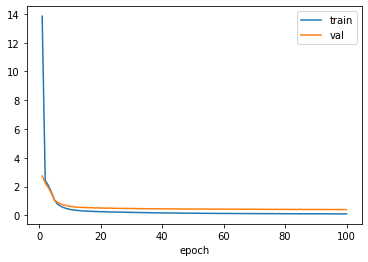

In [ ]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

In [ ]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
ground_truth, predictions = [], []

with torch.no_grad():
    p = True
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        if p:
            print(x_batch.shape, x_batch[:, 0].shape, x_batch[:, 1].shape, minmax)
            print(x_batch[:5, 0])
            print(x_batch[:5, 1])
            p = False
        ground_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

ground_truth = np.asarray(ground_truth).ravel()
predictions = np.asarray(predictions).ravel()

torch.Size([4558, 2]) torch.Size([4558]) torch.Size([4558]) (0.14389421996152751, 23.165259912257692)
tensor([116823,  14277,  14946, 122280,  93102])
tensor([172, 208, 205, 116,  43])


In [ ]:
ground_truth[:5]

array([0.39467922, 0.21079431, 0.99739575, 0.14389423, 0.14389423])

In [ ]:
predictions[:5]

array([0.09750986, 0.38739038, 1.25934458, 0.05924439, 0.15606189])

In [ ]:
final_loss = np.sqrt(np.mean((predictions - ground_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.6355


##### Save and load

In [ ]:
with open('best_weights.pickle', 'wb') as file:
    pickle.dump(best_weights, file)

In [ ]:
# save the trained model
net_path = os.path.join(ROOT_MODELS, 'embeddingNet.pickle')
with open(net_path, 'wb') as f:
    pickle.dump(net, f)

In [78]:
# load it when needed
net_path = os.path.join(ROOT_MODELS, 'embeddingNet.pickle')
with open(net_path, 'rb') as f:
    net = pickle.load(f)

In [80]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [81]:
net.to(device)

EmbeddingNet(
  (u): Embedding(123700, 150)
  (m): Embedding(4558, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

##### Inference example

In [83]:
minmax = float(interactions.strength.min()), float(interactions.strength.max())
minmax

(0.14389421996152751, 23.165259912257692)

In [84]:
# Убедимся, что можем что-то рекомендовать.
with torch.no_grad():
    usrs = torch.tensor([user_to_index['508001152.1612333']] * products.shape[0])
    prods = torch.tensor([product_to_index[pid] for pid in products.product_id])
    pred = net(usrs.to(device),
               prods.to(device),
               minmax)

In [85]:
pred = pred.cpu().detach().numpy()
pred

array([[0.54971683],
       [0.1716882 ],
       [0.5702996 ],
       ...,
       [4.4093857 ],
       [4.0697327 ],
       [5.118343  ]], dtype=float32)

In [87]:
# Предложим топ 10 товаров:
for num in pred.flatten().argsort()[-10 :][: : -1]:
    print(index_to_product_name[num], pred[num])

/utyug-tefal-fv6833e0.html [6.250168]
Кастрюля с крышкой Tefal Cook&Clip 6.1л 22см G7237974 [5.915956]
Сковорода 22 см. + 2 акс Tefal Evidence 04178810 [5.912544]
Стеклянная крышка Tefal Maestro 04198724, 24 см TEFAL Maestro 24 см 04198724 [5.7900147]
Кухонные весы Tefal BC2530V0 [5.6590977]
Сковорода-гриль Tefal Illico 26 см G7011374 [5.6088834]
Сковорода глубокая Tefal Character 22 см C6828375 [5.5897183]
Набор посуды Tefal Ingenio Twinkle Grey 16/22/26см 04180850 [5.5712223]
Картридж-фильтр для гладильных комплексов IXEO Tefal XD5100E0 [5.550066]
Автоматическая кофемашина Krups ESPRESSERIA EA82F010 [5.5488935]


In [ ]:
def make_prediction_embedding_model(user_id: str):
  with torch.no_grad():
    usrs = torch.tensor([user_to_index[user_id]] * products.shape[0])
    prods = torch.tensor([product_to_index[pid] for pid in products.product_id])
    pred = net(usrs.to(device),
               prods.to(device),
               minmax)
    pred = pred.cpu().detach().numpy()

  return (get_purchases(dataframe=dataframe, user_id=user_id),
          [index_to_product_name[num] for num in pred.flatten().argsort()[-10 :][: : -1]])

# Metrics Comparison

Представим метрики и сравним выше приведенные модели. Найдем % действительно интересных посетителю сайта товаров (в итоге купленных) среди всех рекомендуемых моделью.

###### Popularity model Metric

Метрика составила 3,15%. Это означает, что из всех рекомендуемых системой товаров посетитель сайта в итоге купил 3,15%. Это выше органической конверсии сайте(напомним, что это 2.6%), значит, систему можно признать успешной.

In [ ]:
total_recommendations_number: int = 0
total_purchased_in_recommendations_number: int = 0

for user in tqdm(get_checklist_users(top_n=1000, dataframe=dataframe)):
  try:
    purchased_goods, recommended_goods = check_and_recommend_me(user_id=user, model=model_loaded,
                                                            dataframe=dataframe, product_map=product_mappings)
  except KeyError:
    pass
  in_target, out_target, total = count_recommended_and_purchased(purchased_goods, recommended_goods)
  total_recommendations_number += total
  total_purchased_in_recommendations_number += in_target

accuracy(total_purchased_in_recommendations_number, total_recommendations_number)

100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


0.0315

###### Content Based model Metric

Метрика составила 53,69%. Это означает, что из всех рекомендуемых системой товаров посетитель сайта в итоге купил половину. Это значительно выше органической конверсии сайте(напомним, что это 2.6%), значит, систему можно признать успешной. Такой значительный рост точности легко объяснить. Вспомним, что мы брали токены на основе просмотренных пользователей страниц. То есть, шанс "попасть в яблочко" ествественно выше. Если пользователь смотрел кастрюли, то, вероятно, он и купит кастрюлю. Плюс мы снижаем вариантность посредством еще и конкретной интересной серии / размера, то есть выбор для рекомендации системы уже значительно сокращается :)

In [ ]:
total_recommendations_number: int = 0
total_purchased_in_recommendations_number: int = 0

for user in tqdm(get_checklist_users(top_n=1000, dataframe=dataframe)):
  try:
    purchased_goods, recommended_goods = check_and_recommend_me(user_id=user, model=model_loaded_content_based,
                                                            dataframe=dataframe, product_map=product_mappings)
  except KeyError:
    pass
  in_target, out_target, total = count_recommended_and_purchased(purchased_goods, recommended_goods)
  total_recommendations_number += total
  total_purchased_in_recommendations_number += in_target

accuracy(total_purchased_in_recommendations_number, total_recommendations_number)

100%|██████████| 1000/1000 [10:28<00:00,  1.59it/s]


0.5368869936034115

###### EmbeddingNet model Metric

Точность данной модели варьируется от 0.1% точности и до 7.6%, в зависимости от пользователей. Эта модель лучше работает для пользователей, средний чек которых выше (модель предлагает более дорогие товары, но похожие товары, по сравнению с просмотренными и купленными ранее).

In [126]:
total_recommendations_number: int = 0
total_purchased_in_recommendations_number: int = 0

for user in tqdm(get_checklist_users(top_n=1000, dataframe=dataframe)):
  try:
    purchased_goods, recommended_goods = make_prediction_embedding_model(user_id=user)
  except KeyError:
    pass
  in_target, out_target, total = count_recommended_and_purchased(purchased_goods, recommended_goods)
  total_recommendations_number += total
  total_purchased_in_recommendations_number += in_target

accuracy(total_purchased_in_recommendations_number, total_recommendations_number)

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


0.0011

# GUI
Единственная причина, по которой выбран Anvil - удобство работы с Google Colab.

Публичный адрес: https://reco-system.anvil.app/

Адрес для разработки: https://anvil.works/

#### Installs & Imports

In [90]:
# подключаем anvil server
anvil.server.connect('VDQVMDN257VNY55KOC6PAO2B-FSNAT3H7GSBZXRRG')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


#### Functions callable from GUI

Эти функции будут использоваться для отрисовки результатов работы моделей в пользовательском интерфейсе.

In [91]:
@anvil.server.callable
def recommend_for_gui(user: str, model_from_gui: str, top_k: int = 10) -> tuple:
    """
    Runs one of the models above (popularity-based, content-based or EmbeddingNet)
    to recommend products to particular user
    Parameters:
        user (str): user name (or id for anonymized system)
        model_from_gui (str): a string defining the model to run
        top-k (int): number of products to recommend (used for EmbeddingNet only)
    Returns:
        bought (list(str)): list of products bought by the user
        reco (list(str)): list of products recommended to the user
    """
    if model_from_gui == 'popularity':
        reco_model = model_loaded
        reco_func = 1
    elif model_from_gui == 'content':
        reco_model = model_loaded_content_based
        reco_func = 1
    else:
        reco_model = net
        reco_func = 2
    if reco_func == 1:
        bought, reco = check_and_recommend_me(user_id=user,
                                            model=reco_model,
                                            dataframe=dataframe,
                                            product_map=product_mappings)
    else:
        bought = []
        reco = []
        usrs = torch.tensor([user_to_index[user]] * products.shape[0])
        prods = torch.tensor([product_to_index[pid] for pid in products.product_id])
        reco_model.to(device)
        with torch.no_grad():
            pred = reco_model(usrs.to(device),
                              prods.to(device),
                              minmax)
        pred = pred.cpu().detach().numpy().flatten()
        for idx in pred.argsort()[-top_k :][: : -1]:
            reco.append(index_to_product_name[idx])
        subframe = interactions[interactions.clientId == user]
        for _, row in subframe.iterrows():
            bought.append(index_to_product_name[product_to_index[row.hits_product_v2ProductName_]])
    return bought, reco

In [92]:
@anvil.server.callable
def check_user(user: str) -> bool:
    """ Check to distinguish existing users from new users """
    return user in interactions.clientId.unique()

In [ ]:
check_user('307589530.16170114'), check_user('')

(True, False)

In [93]:
# get_checklist_users(top_n=10, dataframe=dataframe)

array(['1901722400.1617904', '1977228463.162253', '921217097.1621792',
       '1238480452.1636543', '1307948565.1637325', '952218200.1636537',
       '862736307.1637344', '2093089601.1621819', '1467661839.162185',
       '1611076918.1621244'], dtype=object)

Интерфейс учитывает как пользователей, которые совершали покупки, так и новых пользователей. Для новых пользователей - используем модель на основе популярных товаров, для остальных же - предлагаем выбор из систем :)

**Вот так выглядит шведский стол:**

Выберем идентификатор клиента, который у нас уже был. Интерфейс покажет нам, что клиент просматривал / купил, а также то, что ему рекомендуется к покупке. Из минусов popularity based: в рекомендациях может встретиться товар, который пользователь уже покупал.

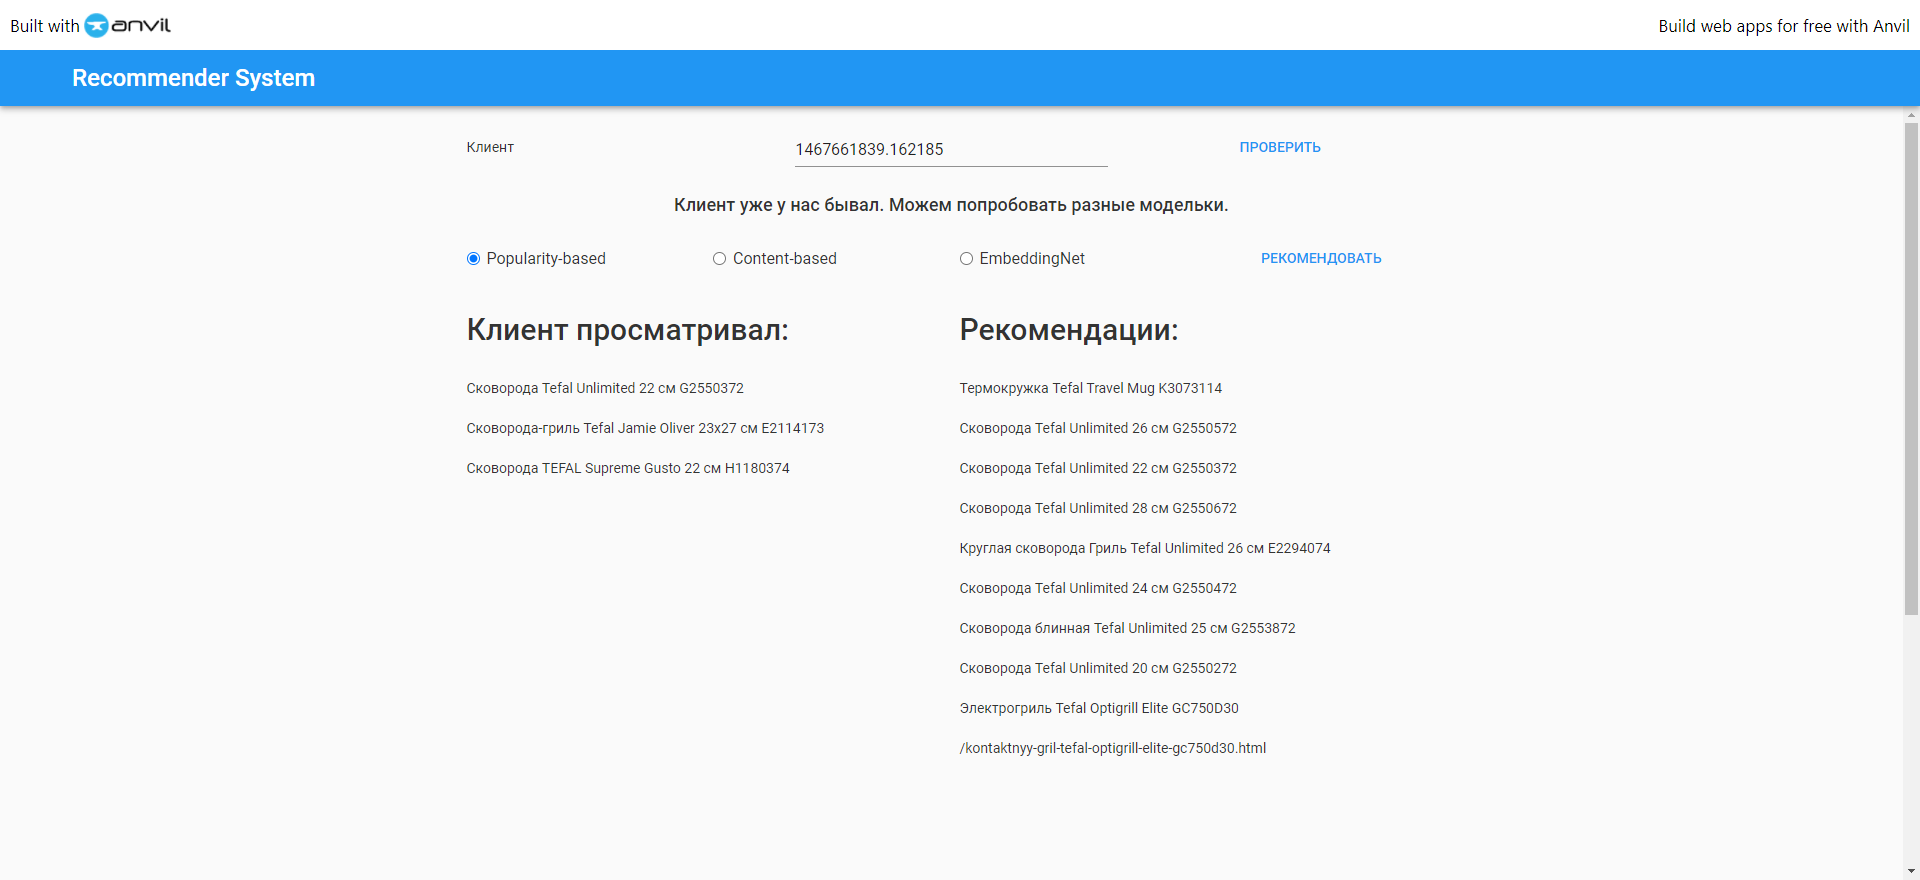

Сменим модель для предсказания и сравним результаты. Судя по всему, рекомендации очень приближены к тому, что искал посетитель. Было бы интересно добавить в модель также характеристики товаров, чтобы рекомендовать еще более близкие продукты.

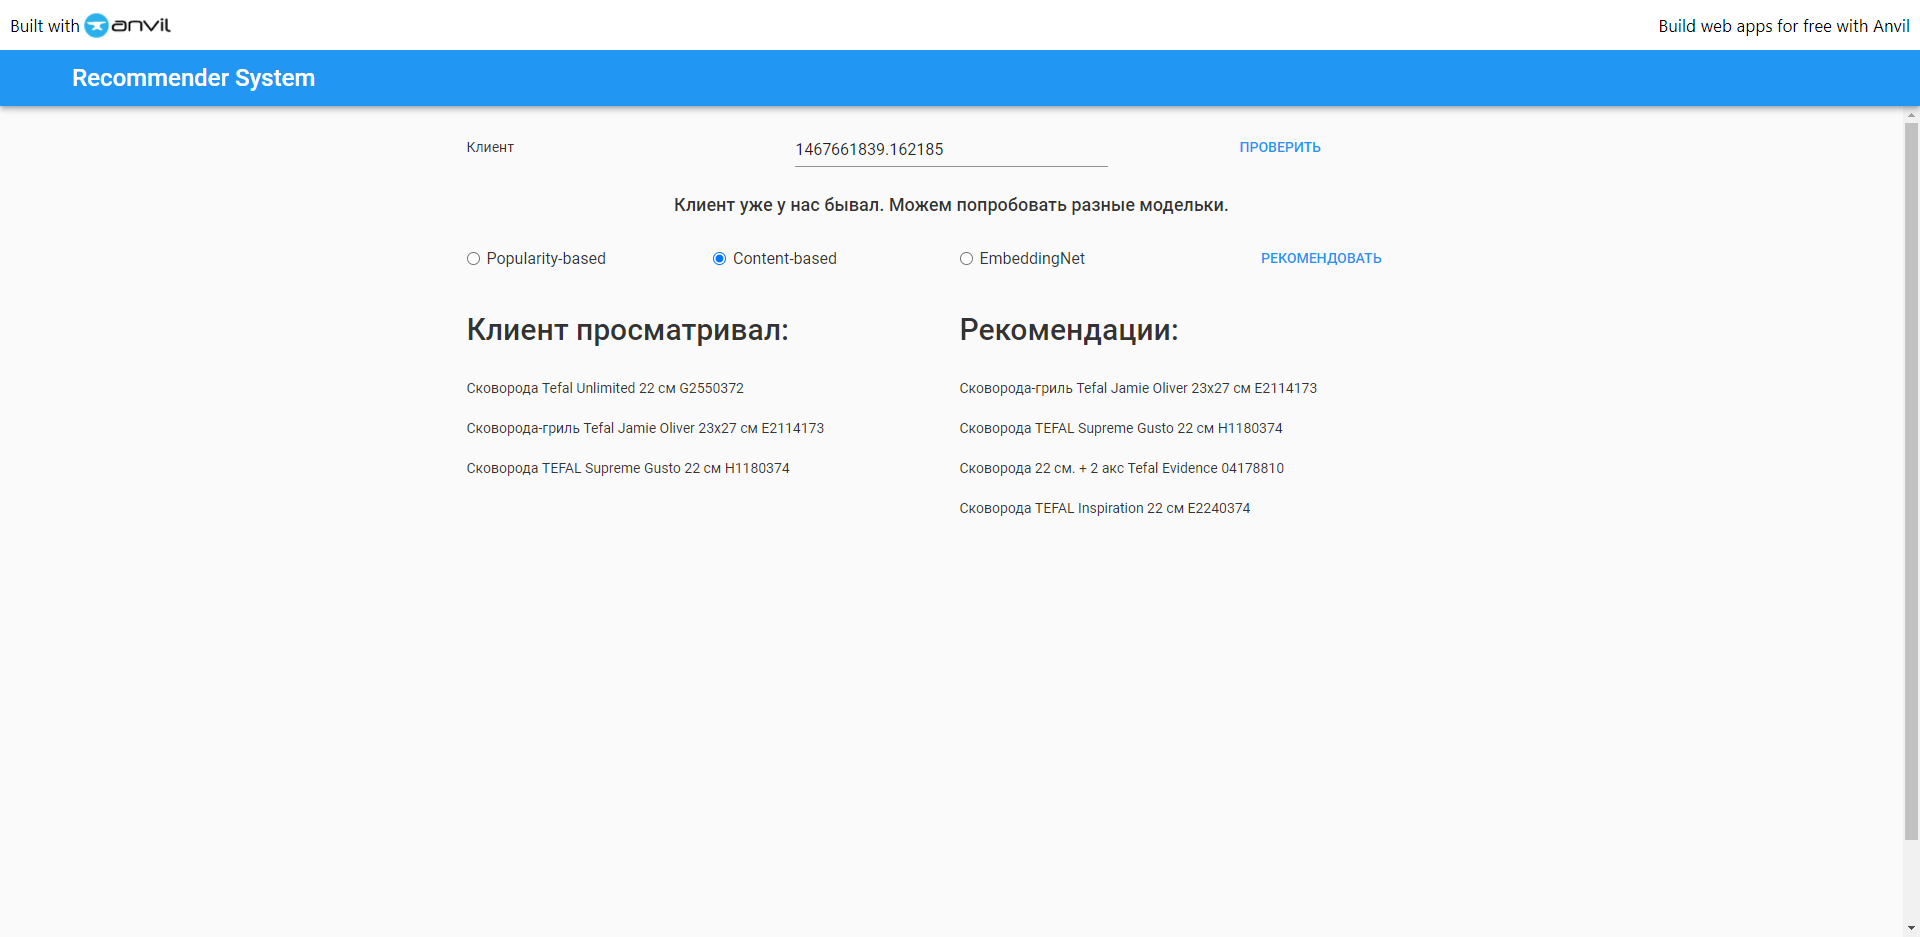

Эта модель, как мы видим, делает рекомендации чуть шире, чем товары в запросах пользователя. Прививаем лояльность и интерес к бренду!
Вендор-оринетированная система :)

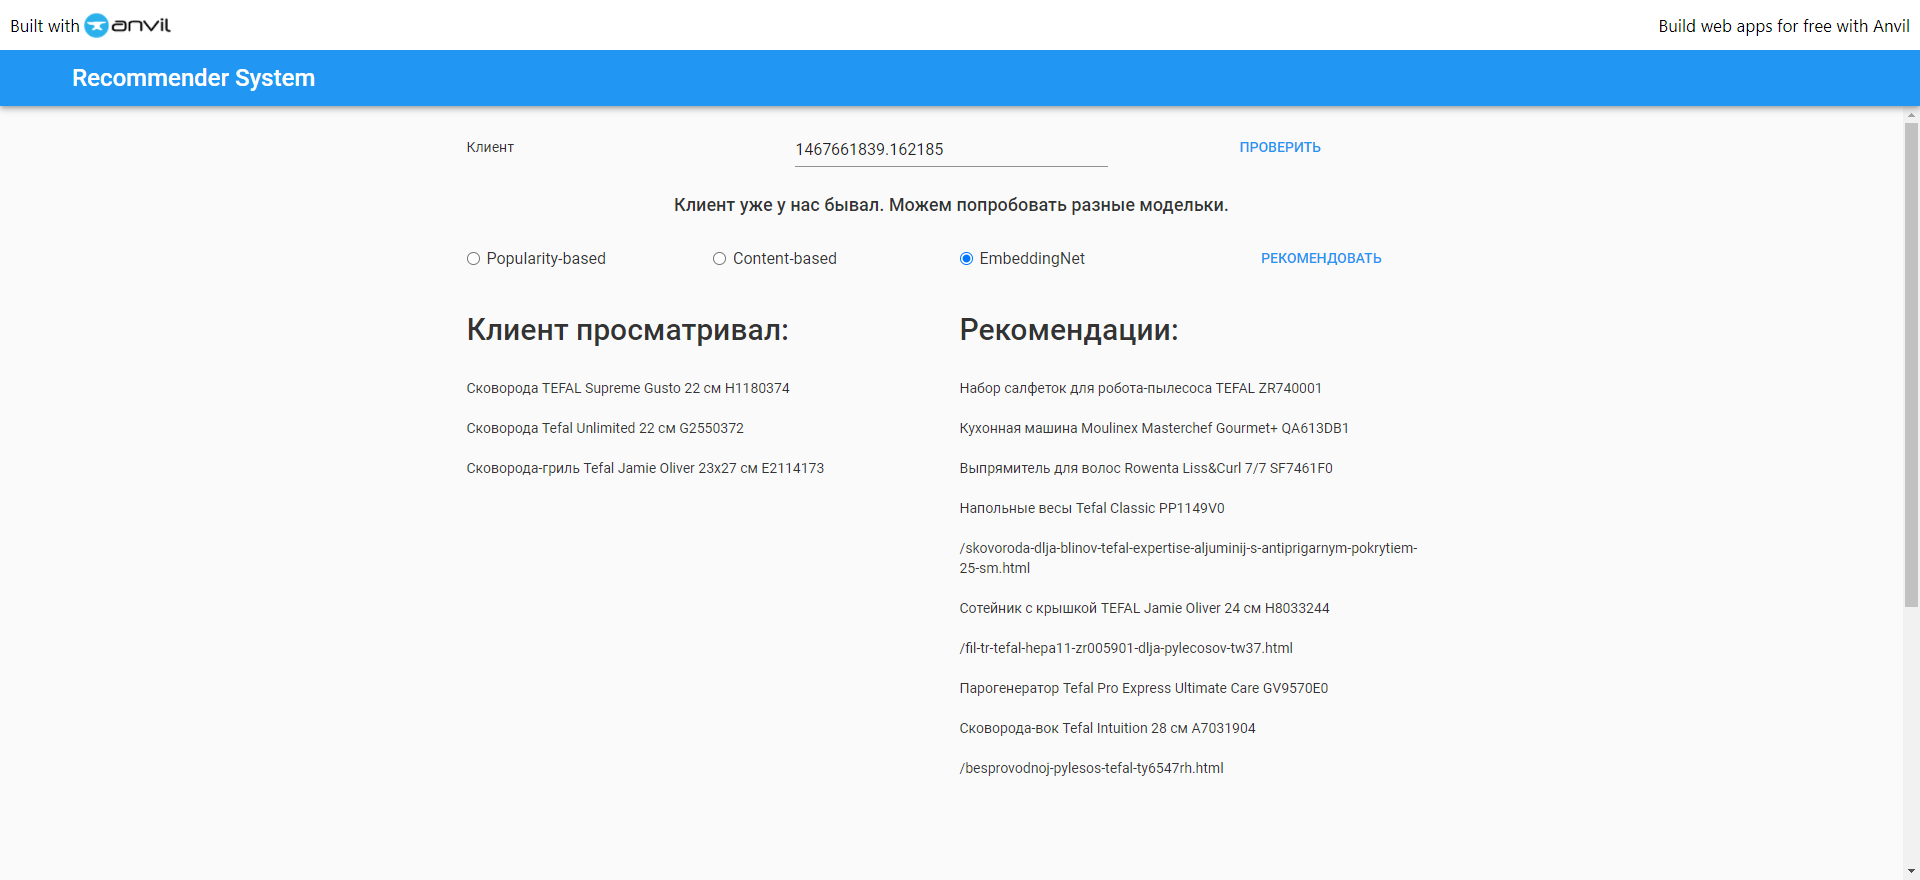

И, напоследок, посмотрим, что нам может предложить система (и интерфейс) для абсолютно нового посетителя нашего сайта:

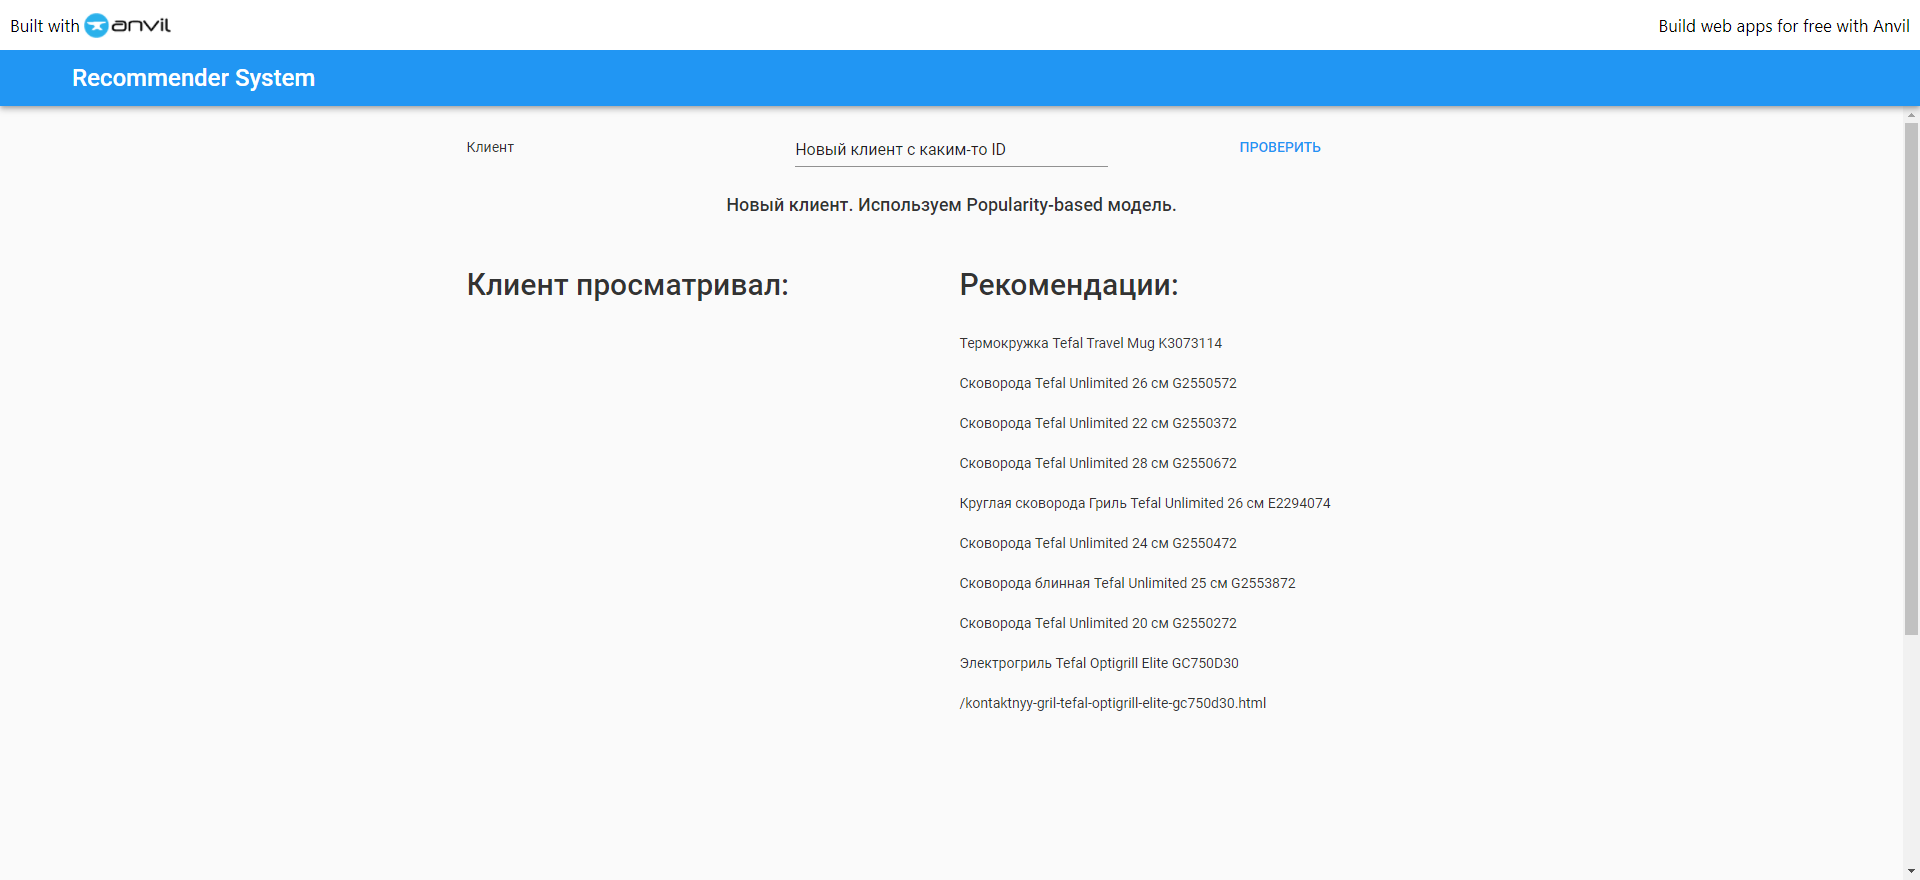